# Data Loading
seperti pada semua kasus/project kita harus mengawali dengan import library yang kita butuhkan pada satu cell ataupun pada masing-masing cell. Pada kasus ini saya akan mengimpornya pada satu cell untuk mempermudah :).

In [26]:
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab import files
import os
import zipfile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

karena disini saya menggunakan dataset yang berasar dari Kaggle, maka saya akan mendownload dataset melalui public API dari Kaggle. Untuk menggunakannya kita harus memasukan ID kita yang berbentuk file JSON terlebih dahulu seperti berikut.

In [2]:
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [3]:
!kaggle datasets download -d ruchi798/bookcrossing-dataset

 89% 68.0M/76.1M [00:00<00:00, 78.8MB/s]
100% 76.1M/76.1M [00:00<00:00, 154MB/s] 


In [4]:
local_zip = '/content/bookcrossing-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
books = pd.read_csv('/content/Books Data with Category Language and Summary/Preprocessed_data.csv')
books

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
3,3,11676,"n/a, n/a, n/a",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN
4,4,41385,"sudbury, ontario, canada",34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031170,1031170,278851,"dallas, texas, usa",33.0000,0743203763,0,As Hogan Said . . . : The 389 Best Things Anyo...,Randy Voorhees,2000.0,Simon & Schuster,http://images.amazon.com/images/P/0743203763.0...,http://images.amazon.com/images/P/0743203763.0...,http://images.amazon.com/images/P/0743203763.0...,Golf lovers will revel in this collection of t...,en,['Humor'],dallas,texas,usa
1031171,1031171,278851,"dallas, texas, usa",33.0000,0767907566,5,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001.0,Broadway Books,http://images.amazon.com/images/P/0767907566.0...,http://images.amazon.com/images/P/0767907566.0...,http://images.amazon.com/images/P/0767907566.0...,A daring twist on the travel-adventure genre t...,en,['Nature'],dallas,texas,usa
1031172,1031172,278851,"dallas, texas, usa",33.0000,0884159221,7,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985.0,Lone Star Books,http://images.amazon.com/images/P/0884159221.0...,http://images.amazon.com/images/P/0884159221.0...,http://images.amazon.com/images/P/0884159221.0...,9,9,9,dallas,texas,usa
1031173,1031173,278851,"dallas, texas, usa",33.0000,0912333022,7,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997.0,Kqed Books,http://images.amazon.com/images/P/0912333022.0...,http://images.amazon.com/images/P/0912333022.0...,http://images.amazon.com/images/P/0912333022.0...,These hilarious stories by the creator of publ...,en,['Fiction'],dallas,texas,usa


In [6]:
books.isnull().sum()

Unnamed: 0                 0
user_id                    0
location                   0
age                        0
isbn                       0
rating                     0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_s                      0
img_m                      0
img_l                      0
Summary                    0
Language                   0
Category                   0
city                   14103
state                  22798
country                35374
dtype: int64

Setelah diload kita lihat bahwa dataset kita memiliki size yang cukup besar yaitu 1031175 atau sekitar 1 jutaan. Sebelum kita masuk ke tahap Univariate Analysis, kita akan drop row 'Unamed: 0', 'img_s', 'img_m', 'img_l', 'Summary', 'location' karena column tersebut tidak terlalu berguna. Alasa column 'location' juga di drop adalah dikarenakan column tersebut sudah direpresentasikan oleh column 'city', 'state', 'country'.

In [7]:
books.drop(['Unnamed: 0', 'img_s', 'img_m', 'img_l', 'Summary', 'location'], inplace=True, axis=1)
books

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,Category,city,state,country
0,2,18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,en,['Social Science'],stockton,california,usa
1,8,34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],timmins,ontario,canada
2,11400,49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],ottawa,ontario,canada
3,11676,34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],NaN,NaN,NaN
4,41385,34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],sudbury,ontario,canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031170,278851,33.0000,0743203763,0,As Hogan Said . . . : The 389 Best Things Anyo...,Randy Voorhees,2000.0,Simon & Schuster,en,['Humor'],dallas,texas,usa
1031171,278851,33.0000,0767907566,5,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001.0,Broadway Books,en,['Nature'],dallas,texas,usa
1031172,278851,33.0000,0884159221,7,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985.0,Lone Star Books,9,9,dallas,texas,usa
1031173,278851,33.0000,0912333022,7,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997.0,Kqed Books,en,['Fiction'],dallas,texas,usa


Halo! Saya menulis ini pada tahap menghitung Cosine Similarity. Jadi pada saat saya ingin menghitung cosine similarity dari project ini, saya menemukan masalah, yaitu runtime saya terus-menerus crashing dikarenakan RAM usagenya sudah maksimal, jika saya mengaktifkan Hardware accelerator GPU muncul error bahwa tidak bisa connect dengan GPU. Hal ini bisa saja dikarenakan saya sering menggunakan GPU ataupun ada hal-hal lain. Oleh karena itu saya disini akan mereduksi dataset size dengan cara drop 50%. Saya sudah mencoba mereduksi < 40% tetapi hasilnya tetap sama yaitu runtime crash.

In [8]:
books.drop(index=range(500000, 1031175), inplace=True, axis=0)
books

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,Category,city,state,country
0,2,18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,en,['Social Science'],stockton,california,usa
1,8,34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],timmins,ontario,canada
2,11400,49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],ottawa,ontario,canada
3,11676,34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],NaN,NaN,NaN
4,41385,34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],sudbury,ontario,canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,85701,37.0000,0743456173,0,Just the Way You Are,Christina Dodd,2003.0,Pocket,en,['Fiction'],savannah,georgia,usa
499996,98391,52.0000,0743456173,8,Just the Way You Are,Christina Dodd,2003.0,Pocket,en,['Fiction'],morrow,georgia,usa
499997,107865,34.7439,0743456173,0,Just the Way You Are,Christina Dodd,2003.0,Pocket,en,['Fiction'],tampa,florida,usa
499998,114368,33.0000,0743456173,0,Just the Way You Are,Christina Dodd,2003.0,Pocket,en,['Fiction'],mechanicsville,maryland,usa


# Univariate Data Analysis
Sebelum kita masuk kedalam tahap Data Preparation, kita bisa memasuki tahap Data Analysis terlebih dahulu untuk mengetahui data pada dataset ini. Pada tahap ini saya akan menggunakan teknik Univariate Data Analysis. Teknik ini adalah teknik paling dasar untuk menganalysis data. Secara singkat Uni berarti satu, yang berarti menganalysis data secara terpisah (satu per satu). Tujuannya adalah untuk melihat dan memberikan insight mengenai data kita. Karena data kita sudah di rangkum maka kita tidak bisa melakukan analysis secara terpisah.

In [9]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              500000 non-null  int64  
 1   age                  500000 non-null  float64
 2   isbn                 500000 non-null  object 
 3   rating               500000 non-null  int64  
 4   book_title           500000 non-null  object 
 5   book_author          500000 non-null  object 
 6   year_of_publication  500000 non-null  float64
 7   publisher            500000 non-null  object 
 8   Language             500000 non-null  object 
 9   Category             500000 non-null  object 
 10  city                 487830 non-null  object 
 11  state                483393 non-null  object 
 12  country              475825 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 53.4+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d66eb8790>,
      dtype=object)

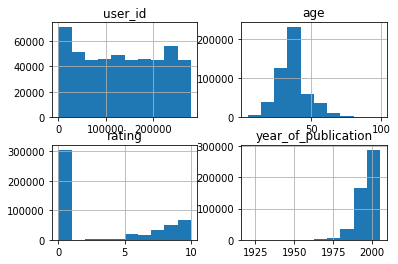

In [10]:
books.hist()

In [11]:
books.isnull().sum()

user_id                    0
age                        0
isbn                       0
rating                     0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
Language                   0
Category                   0
city                   12170
state                  16607
country                24175
dtype: int64

In [12]:
print('jumlah data: ', len(books))
print('skala rating dari {0} sampai {1}'.format(books['rating'].min(), books['rating'].max()))
print('banyak kategori buku: ', len(books['Category'].unique()))
print('macam-macam bahasa dalam buku: ', books['Language'].unique())

jumlah data:  500000
skala rating dari 0 sampai 10
banyak kategori buku:  1389
macam-macam bahasa dalam buku:  ['en' '9' 'de' 'fr' 'es' 'ca' 'it' 'da' 'nl' 'pt' 'gl' 'ro' 'no' 'el']


In [13]:
books[books['Language']=='9']

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,Category,city,state,country
68,8,34.7439,0671870432,0,PLEADING GUILTY,Scott Turow,1993.0,Audioworks,9,9,timmins,ontario,canada
69,11676,34.7439,0671870432,8,PLEADING GUILTY,Scott Turow,1993.0,Audioworks,9,9,NaN,NaN,NaN
70,24539,34.7439,0671870432,0,PLEADING GUILTY,Scott Turow,1993.0,Audioworks,9,9,cabrils,catalunya,spain
80,8,34.7439,0887841740,5,The Middle Stories,Sheila Heti,2004.0,House of Anansi Press,9,9,timmins,ontario,canada
81,92861,34.7439,0887841740,0,The Middle Stories,Sheila Heti,2004.0,House of Anansi Press,9,9,vancouver,british columbia,canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499930,125519,40.0000,0688123163,0,Raving Fans : A Revolutionary Approach To Cust...,Ken Blanchard,1993.0,William Morrow,9,9,irvine,california,usa
499935,13552,32.0000,0743225635,9,Love on a Rotten Day : An Astrological Surviva...,Hazel Dixon-Cooper,2004.0,Fireside,9,9,cordova,tennessee,usa
499936,65322,34.7439,0743225635,0,Love on a Rotten Day : An Astrological Surviva...,Hazel Dixon-Cooper,2004.0,Fireside,9,9,menlo park,california,usa
499960,13552,32.0000,0743257464,0,Self-Empowerment Journal : A Companion to The ...,Gary Zukav,2003.0,Free Press,9,9,cordova,tennessee,usa


Kita dapat simpulkan bahwa column 'city', 'state', dan 'country' terdapat nilai yang bernilai NaN, ini berarti pada column tersebut terdapat missing value. Jika kita perhatikan lagi kita bisa lihat bahwa pada column 'Language', dan 'Category' juga terdapat missing value yang direpresentasikan dengan nilai '9', nilai tersebut dapat dibilang missing value dikarenakan tidak mungkin column 'Language', dan 'Category' memiliki nilai yang sama yaitu '9'. Jumlah dari colum yang memiliki nilai '9' ini juga cukup banyak yaitu sebesar 398937. Kita akan tangani semua missing value ini pada tahap Data Cleaning. Selanjutnya kita akan masuk pada tahap Data Preparation

# Data Preparation
Pada tahap Data Preparation, disini saya tidak akan melakukan teknik-teknik untuk preparasi karena dataset yang saya gunakan ini sudah tergabung semua, atau bisa dibilang siap digunakan dan hanya perlu melakukan preprocessing dan cleaning dari missing value. Oleh karena itu disini saya tidak akan melakukan apa-apa selain dari melakukan teknik Sorting dengan fungsi .sort_value

In [14]:
books = books.sort_values('isbn', ascending=True)
books

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,Category,city,state,country
478203,11944,21.0000,0001047973,9,Brave New World,Aldous Huxley,1999.0,Trafalgar Square Publishing,9,9,santo tirso,porto,portugal
478204,23902,34.7439,0001047973,9,Brave New World,Aldous Huxley,1999.0,Trafalgar Square Publishing,9,9,london,england,united kingdom
384112,10067,61.0000,0001360469,10,Babe Dressing,Mandy Stanley,1997.0,HarperCollins Publishers,9,9,watton,norfolk,england
384113,10067,61.0000,0001374869,10,Baby Plays (Collins Baby and Toddler Series),Fiona Pragoff,1994.0,HarperCollins Publishers,9,9,watton,norfolk,england
384115,224654,34.7439,000160418X,0,The Clue in the Crumbling Wall,Carolyn Keene,1984.0,HarperCollins Publishers,9,9,watton,england,united kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369649,9029,34.7439,B0000A2U93,7,Carmilla,Joseph Sheridan Le Fanu,1994.0,Soft Editions Ltd,9,9,gavà,barcelona,spain
369650,13093,29.0000,B0000A2U93,0,Carmilla,Joseph Sheridan Le Fanu,1994.0,Soft Editions Ltd,9,9,zaragoza,aragon,spain
132962,1903,36.0000,B0000DAPP1,5,Discover Your Genius: How to Think Like Histor...,Michael J. Gelb,2002.0,HarperCollins,9,9,hualien,taiwan,taiwan
476606,11676,34.7439,B0000DYXID,10,A Kid's Guide To How to Save the Planet,Billy Goodman,1994.0,"iBooks, Inc.",9,9,NaN,NaN,NaN


# Data Cleaning
Seperti yang sudah dibilang pada bagian Univariate Analysis, data kita memiliki missing value yang cukup banyak. Oleh karena itu pada tahap ini kita akan mengani missing value. 

Untuk menangani

In [15]:
books.isnull().sum()

user_id                    0
age                        0
isbn                       0
rating                     0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
Language                   0
Category                   0
city                   12170
state                  16607
country                24175
dtype: int64

In [16]:
books = books.replace(to_replace='9', value=np.nan)
books[books['Language']=='9'].sum()

user_id                0.0
age                    0.0
isbn                   0.0
rating                 0.0
book_title             0.0
book_author            0.0
year_of_publication    0.0
publisher              0.0
Language               0.0
Category               0.0
city                   0.0
state                  0.0
country                0.0
dtype: float64

In [17]:
len(books[books['Language']=='9'])
books.isnull().sum()

user_id                     0
age                         0
isbn                        0
rating                      0
book_title                  0
book_author                 0
year_of_publication         0
publisher                   0
Language               176176
Category               178061
city                    12170
state                   16607
country                 24175
dtype: int64

Sekarang kita bisa lihat bahwa kita memiliki missing value yang sangat banyak yaitu sebesar 406102! Selanjutnya kita akan drop semua nilai NaN.

In [18]:
books = books.dropna()

In [19]:
books.isnull().sum()

user_id                0
age                    0
isbn                   0
rating                 0
book_title             0
book_author            0
year_of_publication    0
publisher              0
Language               0
Category               0
city                   0
state                  0
country                0
dtype: int64

In [20]:
print('after data cleaning dataset size:', len(books))

after data cleaning dataset size: 303428


In [21]:
len(books['Category'].unique())

1381

Sekarang data kita sudah bersih, tetapi kita mengalami data loss lebih dari 40%, yang dapat dibilang cukup signifikan. Selanjutnya kita akan drop semua ISBN yang duplika, hal ini dilakukan agar hanya ada buku yang unique saja. Kita akan drop dengan fungsi .drop_duplicates() [06](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html). 

In [22]:
preparation = books
preparation = preparation.drop_duplicates('isbn')
preparation

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,Category,city,state,country
4,41385,34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],sudbury,ontario,canada
494515,13222,43.0000,0002005395,8,Deafening,Frances Itani,2003.0,HarperFlamingo Canada,en,['Fiction'],montreal,quebec,canada
409927,175119,48.0000,0002118580,0,Audacity to believe,Sheila Cassidy,1977.0,Collins,en,['Catholics'],adelaide,south australia,australia
399241,11601,34.7439,0002179687,0,Christmas in America: Images of the Holiday Se...,David Cohen,1988.0,Collins Pub San Francisco,en,['Social Science'],brooklyn,new york,usa
384116,10067,61.0000,0002219476,0,The way to dusty death,Alistair MacLean,1973.0,Collins,en,['Adventure stories'],watton,norfolk,england
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243594,5277,26.0000,9839236083,0,Corruption and the Destiny of Asia,Syed Hussein Alatas,2000.0,Pearson Professional Education,en,['Political corruption'],bangsar,kuala lumpur,malaysia
357710,140168,24.0000,9871138016,10,Cronica De Una Muerte Anunciada,Gabriel Marques Garcia,2002.0,Debols!llo,es,['Colombian fiction'],paris,ile de france,france
320134,7181,24.0000,9875500534,10,Bodas de Sangre,Federico Garcia Lorca,2001.0,Errepar,en,['Weddings'],oviedo,asturias,spain
393573,260406,28.0000,9960340112,8,A Brief Illustrated Guide To Understanding Islam,I. A. Ibrahim,1999.0,Dar Us Salam Pubns,en,['Religion'],plainville,massachusetts,usa


## Feature Selection

In [23]:
references = ['isbn', 'book_title', 'book_author', 'publisher', 'Language', 'Category']

book_isbn = preparation[references[0]].tolist()
 
book_title = preparation[references[1]].tolist()
 
book_author = preparation[references[2]].tolist()

book_publisher = preparation[references[3]].tolist()

book_lang = preparation[references[4]].tolist()

book_category = preparation[references[5]].tolist()
 
print(len(book_isbn))
print(len(book_title))
print(len(book_author))
print(len(book_publisher))
print(len(book_lang))
print(len(book_category))

18636
18636
18636
18636
18636
18636


In [24]:
books_new = pd.DataFrame({
    'isbn': book_isbn,
    'title': book_title,
    'author': book_author,
    'publisher': book_publisher,
    'language': book_lang,
    'category': book_category
})
books_new

,isbn,title,author,publisher,language,category
0,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,en,['Actresses']
1,0002005395,Deafening,Frances Itani,HarperFlamingo Canada,en,['Fiction']
2,0002118580,Audacity to believe,Sheila Cassidy,Collins,en,['Catholics']
3,0002179687,Christmas in America: Images of the Holiday Se...,David Cohen,Collins Pub San Francisco,en,['Social Science']
4,0002219476,The way to dusty death,Alistair MacLean,Collins,en,['Adventure stories']
...,...,...,...,...,...,...
18631,9839236083,Corruption and the Destiny of Asia,Syed Hussein Alatas,Pearson Professional Education,en,['Political corruption']
18632,9871138016,Cronica De Una Muerte Anunciada,Gabriel Marques Garcia,Debols!llo,es,['Colombian fiction']
18633,9875500534,Bodas de Sangre,Federico Garcia Lorca,Errepar,en,['Weddings']
18634,9960340112,A Brief Illustrated Guide To Understanding Islam,I. A. Ibrahim,Dar Us Salam Pubns,en,['Religion']


# Modelling

In [27]:
data = books_new

In [29]:
vec = CountVectorizer()
 
vec.fit(data['category']) 
 
vec.get_feature_names() 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1863',
 '1939',
 '1940',
 '1943',
 '1945',
 '1949',
 '1975',
 '87th',
 '90210',
 'abandoned',
 'abduction',
 'ability',
 'abolitionists',
 'aboriginal',
 'abortion',
 'abuse',
 'abused',
 'abusive',
 'academic',
 'acapulco',
 'accelerated',
 'accident',
 'accidents',
 'accommodations',
 'acquaintance',
 'acting',
 'action',
 'activities',
 'actors',
 'actresses',
 'actualization',
 'acupressure',
 'adam',
 'adirondack',
 'administration',
 'adobe',
 'adolescence',
 'adolescent',
 'adopted',
 'adoption',
 'adult',
 'adulteresses',
 'adultery',
 'adults',
 'adventure',
 'adventurers',
 'advice',
 'aeronautics',
 'aerospace',
 'affirmations',
 'afghan',
 'afghanistan',
 'africa',
 'african',
 'afro',
 'aged',
 'agents',
 'aging',
 'ahab',
 'ahead',
 'aids',
 'air',
 'airborne',
 'aircraft',
 'aires',
 'airplanes',
 'alabama',
 'alamo',
 'alan',
 'alaska',
 'alberta',
 'alcarria',
 'alchemists',
 'alcoholics',
 'alcoholism',
 'alden',
 'alex',
 'alice',
 'alien',
 'alienation',
 'aliens'

In [30]:
vec_matrix = vec.fit_transform(data['category']) 
 
vec_matrix.shape 

(18636, 1539)

In [31]:
vec_matrix.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

# Cosine Similarity

In [33]:
cosine_sim = cosine_similarity(vec_matrix) 
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [34]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)
 
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (18636, 18636)


title,Murder in a Hot Flash: A Charlie Greene Mystery (Charlie Green Mysteries (Paperback)),Another Roadside Attraction,Il Giovane Holden,A Density of Souls,Same-Sex Love : And the Path to Wholeness
title,,,,,
Compassion for All Creatures: An Inspirational Guide for Healing the Ostrich Syndrome,0.0,0.0,0.0,0.0,0.0
Private Indiscretions,1.0,1.0,1.0,1.0,0.0
Lady Oracle,1.0,1.0,1.0,1.0,0.0
Gravity (A),1.0,1.0,1.0,1.0,0.0
The Html Sourcebook: A Complete Guide to Html 3.0,0.0,0.0,0.0,0.0,0.0
Lady With Lapdog and Other Stories (Penguin Classics),1.0,1.0,1.0,1.0,0.0
"Like Water for Chocolate: A Novel in Monthly Installments, With Recipes, Romances, and Home Remedies",1.0,1.0,1.0,1.0,0.0
Picture Perfect,1.0,1.0,1.0,1.0,0.0
Life As a Daymaker: How to Change the World by Simply Making Someone's Day,0.0,0.0,0.0,0.0,0.0


In [35]:
def get_recommendations(book_title, similarity_data=cosine_sim_df, items=data[['title', 'category']], k=5):
    index = similarity_data.loc[:,book_title].to_numpy().argpartition(
        range(-1, -k, -1))
    
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    closest = closest.drop(book_title, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

# Evaluation

In [36]:
books.sample(10)

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,Category,city,state,country
187917,225886,35.0000,0061030635,8,Wild Justice,Phillip Margolin,2001.0,HarperTorch,en,['Fiction'],ruma,illinois,usa
251344,49109,38.0000,1551669498,0,Girls Night,Stef Ann Holm,2002.0,Mira,en,['Fiction'],west jordan,utah,usa
172929,107453,18.0000,0671695126,10,Secrets of the Morning (Cutler),V.C. Andrews,1991.0,Pocket,en,['Fiction'],chunchula,alabama,usa
291481,133689,29.0000,055356773X,0,The Cereal Murders,Diane Mott Davidson,1994.0,Crimeline,en,['Fiction'],calgary,alberta,canada
448492,105374,25.0000,0553564668,0,What Falls Away: A Memoir,Mia Farrow,1998.0,Bantam Books,en,['Biography & Autobiography'],montreal,quebec,canada
194190,18172,36.0000,0425109240,0,The Timothy Files,Lawrence Sanders,1994.0,Berkley Publishing Group,en,['Fiction'],levittown,pennsylvania,usa
380671,228547,15.0000,0618055819,8,Gathering Blue,Lois Lowry,2000.0,Walter Lorraine Books,en,['Juvenile Fiction'],centerport,new york,usa
9417,204813,34.7439,0786868716,8,The Five People You Meet in Heaven,Mitch Albom,2003.0,Hyperion,en,['Fiction'],jersey city,new jersey,usa
456071,81048,32.0000,0679735666,0,A Natural History of the Senses,Diane Ackerman,1991.0,Vintage Books USA,en,['Family & Relationships'],west haven,connecticut,usa
276850,94853,27.0000,0590738720,9,The Magic School Bus Going Batty: A Book About...,Nancy E. Krulik,1996.0,Scholastic,en,['Animals'],christchurch,canterbury,new zealand


In [37]:
books[books['book_title']=='Dragonshadow']

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,Category,city,state,country
340137,7947,34.7439,0345421884,3,Dragonshadow,Barbara Hambly,2000.0,Del Rey Books,en,['Fiction'],rockville,maryland,usa
340138,115488,22.0000,0345421884,0,Dragonshadow,Barbara Hambly,2000.0,Del Rey Books,en,['Fiction'],sydney,new south wales,australia
340140,203369,34.7439,0345421884,5,Dragonshadow,Barbara Hambly,2000.0,Del Rey Books,en,['Fiction'],houston,texas,usa
340141,257204,32.0000,0345421884,0,Dragonshadow,Barbara Hambly,2000.0,Del Rey Books,en,['Fiction'],akron,ohio,usa
340139,171118,47.0000,0345421884,6,Dragonshadow,Barbara Hambly,2000.0,Del Rey Books,en,['Fiction'],toronto,ontario,canada
340142,264321,33.0000,0345421884,0,Dragonshadow,Barbara Hambly,2000.0,Del Rey Books,en,['Fiction'],toronto,ontario,canada


In [38]:
get_recommendations('Dragonshadow', k=10)

,title,category
0,Los amigos que perdÃ­,['Fiction']
1,"Tall, Dark, and Cajun",['Fiction']
2,Burndive,['Fiction']
3,The Sniper's Wife,['Fiction']
4,The Kingmaker,['Fiction']
5,Blood Games,['Fiction']
6,Blood Games,['Fiction']
7,Working Men,['Fiction']
8,The Jester,['Fiction']
9,License to Thrill,['Fiction']


In [39]:
def get_precision(relev, sum):
    percentage = print('Recommendation System Precision Percentage: {0}%'.format((relev / sum * 100)))
    return percentage

get_precision(10, 10)

Recommendation System Precision Percentage: 100.0%


Mari kita coba dengan buku yang lain.

In [40]:
get_recommendations('Under the Tuscan Sun: At Home in Italy', k=20)

,title,category
0,The McDougall Health-Supporting Cookbook: Volu...,['Cooking']
1,America's Best Slow Cooker Recipes,['Cooking']
2,English Royal Cookbook: Favorite Court Recipes...,['Cooking']
3,Gifts in a Jar: Bars & Brownies,['Cooking']
4,"Tea Time/Tradition, Presentation, and Recipes ...",['Cooking']
5,Miami Spice: The New Florida Cuisine,['Cooking']
6,Breakfast Book,['Cooking']
7,"I'm In The Wine Store, Now What?: Understandin...",['Cooking']
8,Desperation Dinners!,['Cooking']
9,Barefoot Contessa Parties! Ideas and Recipes f...,['Cooking']


In [41]:
get_precision(20, 20)

Recommendation System Precision Percentage: 100.0%
